<font size="6"> **Alpha Factor Evaluation** </font>

Run notebook on quant-ai4trading environment

In [1]:
%%capture
%run 01_alphafac_calc_and_fwdrets.ipynb

In [2]:
import datetime as dt
from scipy.stats import spearmanr

In [3]:
print(universe_start_date, universe_end_date, factor_start_date)

2011-01-05 00:00:00+00:00 2016-01-05 00:00:00+00:00 2014-01-03 00:00:00+00:00


In [4]:
print(factor_start_date)

2014-01-03 00:00:00+00:00


In [5]:
print('Number of tickers: {}'.format(len(universe_tickers)))

Number of tickers: 490


In [6]:
print("The factor names are {}".format(factor_names))

The factor names are Index(['Momentum_1YR', 'Smoothed_Momentum_1YR', 'rets_1d_raw', 'rets_1y_raw',
       'sector_code'],
      dtype='object')


# Factor Evaluation: Forward Returns

Factor Evaluation Techniques:
* Factor (Weighted) returns: 
* Sharpe ratio
* Ranked Information coefficient (IC)
* Information Ratio (IR)
* Factor Rank Autocorrelation (FRA)
* Quantile Analysis 
* Turnover analysis
* Transfer Coefficient

First of all, forward returns must be computed and then use a evaluation technique that rely on that forward returns. To achieve that, alphalens functionalities provides easy calculation, data alignment etc.

## Factor (Weighted) Returns and Sharpe Ratio
Return on a theoretical portfolio, performing weight calculation driven by the alpha factor itself. Usefull when date range and universe is the same

Reference: A good Alpha-factor, may have an annual return of 4% (400bps)

### Alphalens factor_returns

Alphalens has a function that calculates the factor returns, called alphalens.performance.factor_returns.  The [documentation is here](https://quantopian.github.io/alphalens/alphalens.html?highlight=factor_returns#alphalens.performance.factor_returns).  

```python
def factor_returns(factor_data, demeaned, group_adjust, equal_weight, by_asset)
"""
Computes period wise returns for portfolio weighted by factor values.

Parameters:
factor_data : pd.DataFrame - MultiIndex

A MultiIndex DataFrame indexed by date (level 0) and asset (level 1), containing the values for a single alpha factor, forward returns for each period, the factor quantile/bin that factor value belongs to, and (optionally) the group the asset belongs to. - See full explanation in utils.get_clean_factor_and_forward_returns

demeaned : bool

Control how to build factor weights – see performance.factor_weights for a full explanation

group_adjust : bool

Control how to build factor weights – see performance.factor_weights for a full explanation

equal_weight : bool, optional

Control how to build factor weights – see performance.factor_weights for a full explanation

by_asset: bool, optional

If True, returns are reported separately for each asset.
"""

```

* factor_data: Pass in the pre-processed dataframe that we got back from the previous alphalens function.
* returns: the return of a theoretical portfolio that is weighted according to the factor.  This is the factor-weighted return, also called the factor return.

In [7]:
for k, v in factor_data.items():
    print(k, v.head(2))

rets_1y_raw                                                  1D    factor  factor_quantile
date                      asset                                               
2014-01-06 00:00:00+00:00 Equity(0 [A])    0.015168  0.806821                5
                          Equity(1 [AAL]) -0.004649  0.801862                5
rets_1d_raw                                                  1D    factor  factor_quantile
date                      asset                                               
2014-01-06 00:00:00+00:00 Equity(0 [A])    0.015168  0.006951              4.0
                          Equity(1 [AAL]) -0.004649  0.046523              5.0
Smoothed_Momentum_1YR                                                  1D    factor  factor_quantile
date                      asset                                               
2014-01-06 00:00:00+00:00 Equity(0 [A])    0.015168  1.491787                5
                          Equity(1 [AAL]) -0.004649  1.556848                5
sector

In [8]:
ls_factor_return = []

for i, factor_name in enumerate(factor_names):
    factor_return = al.performance.factor_returns(factor_data[factor_name])
    factor_return.columns = [factor_name]
    ls_factor_return.append(factor_return)

In [9]:
unsmoothed_factor_return = ls_factor_return[0]
smoothed_factor_return = ls_factor_return[1]

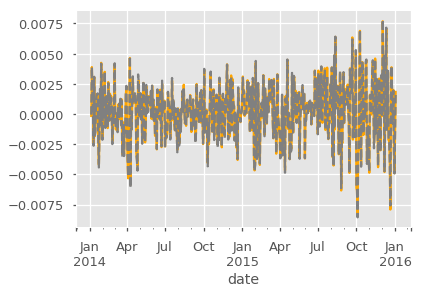

In [10]:
unsmoothed_factor_return['Momentum_1YR'].plot(color='orange')
smoothed_factor_return['Smoothed_Momentum_1YR'].plot(color='gray',style='--');

## Sharpe Ratio

Also known as risk adjusted returns

$$\text{Sharpe-ratio=}\frac{\mu_{annulized}}{\sigma_{annulized}}$$

$$ r_{daily-annualized}= r_{daily} * \sqrt(252)$$

In [11]:
def compute_sharpe_ratio(df, frequency="daily"):

    if frequency == "daily":
        annualization_factor = np.sqrt(252)
    elif frequency == "monthly":
        annualization_factor = np.sqrt(12)
    else:
        annualization_factor = 1
    
    return annualization_factor*df.mean()/df.std()

In [12]:
compute_sharpe_ratio(ls_factor_return[0])

Momentum_1YR    1.13369
dtype: float64

In [13]:
compute_sharpe_ratio(ls_factor_return[1])

Smoothed_Momentum_1YR    1.101621
dtype: float64

# Rank IC

Compute rank correlation at each time period between alpha vector and forward returns

The [factor_information_coefficient function in alphalens documentation is here.](https://quantopian.github.io/alphalens/alphalens.html#alphalens.performance.factor_information_coefficient)

```
Computes the Spearman Rank Correlation based Information Coefficient (IC) between factor values and N period forward returns for each period in the factor index.

Parameters:
factor_data : pd.DataFrame - MultiIndex

A MultiIndex DataFrame indexed by date (level 0) and asset (level 1), containing the values for a single alpha factor, forward returns for each period, the factor quantile/bin that factor value belongs to, and (optionally) the group the asset belongs to. - See full explanation in utils.get_clean_factor_and_forward_returns

group_adjust : bool

Demean forward returns by group before computing IC.

by_group : bool

If True, compute period wise IC separately for each group.

Returns:
ic : pd.DataFrame

Spearman Rank correlation between factor and provided forward returns.
```

In [14]:
ls_rank_ic = []

for i, factor_name in enumerate(factor_names):
    rank_ic = al.performance.factor_information_coefficient(factor_data[factor_name])
    rank_ic.columns = [factor_name]
    ls_rank_ic.append(rank_ic)

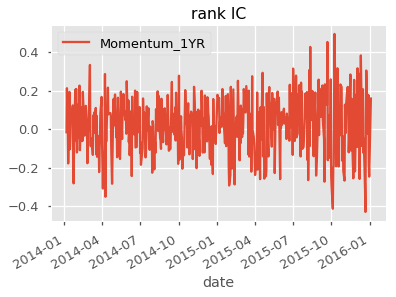

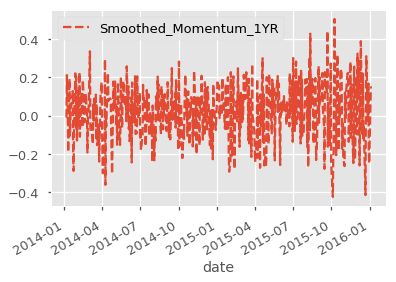

In [15]:
ls_rank_ic[0].plot(title="rank IC")
ls_rank_ic[1].plot(style='--');

In [16]:
factor_names[0]

'Momentum_1YR'

In [17]:
factor_data[factor_names[0]].head()

1D    factor  \
date                      asset                                  
2014-01-06 00:00:00+00:00 Equity(0 [A])     0.015168  1.521549   
                          Equity(1 [AAL])  -0.004649  1.573252   
                          Equity(2 [AAP])   0.012343  0.598279   
                          Equity(3 [AAPL]) -0.007163 -1.469846   
                          Equity(4 [ABBV])  0.001998  1.004518   

                                            factor_quantile  
date                      asset                              
2014-01-06 00:00:00+00:00 Equity(0 [A])                   5  
                          Equity(1 [AAL])                 5  
                          Equity(2 [AAP])                 4  
                          Equity(3 [AAPL])                1  
                          Equity(4 [ABBV])                4

In [18]:
factor_data[factor_names[0]].loc[('2014-01-06', slice(None)), 'factor'].head()

date                       asset           
2014-01-06 00:00:00+00:00  Equity(0 [A])       1.521549
                           Equity(1 [AAL])     1.573252
                           Equity(2 [AAP])     0.598279
                           Equity(3 [AAPL])   -1.469846
                           Equity(4 [ABBV])    1.004518
Name: factor, dtype: float64

In [19]:
factor_data[factor_names[0]].loc[('2014-01-06', slice(None)), '1D'].head()

date                       asset           
2014-01-06 00:00:00+00:00  Equity(0 [A])       0.015168
                           Equity(1 [AAL])    -0.004649
                           Equity(2 [AAP])     0.012343
                           Equity(3 [AAPL])   -0.007163
                           Equity(4 [ABBV])    0.001998
Name: 1D, dtype: float64

In [20]:

spearmanr(
    factor_data[factor_names[0]].loc[('2014-01-06', slice(None)), '1D'],
    factor_data[factor_names[0]].loc[('2014-01-06', slice(None)), 'factor']
)

SpearmanrResult(correlation=-0.01597480816672531, pvalue=0.7300524311097127)

In [21]:
ls_rank_ic[0].loc['2014-01-06']

Momentum_1YR   -0.015975
Name: 2014-01-06 00:00:00+00:00, dtype: float64

# Information Ratio (IR) and Factor Autocorrelation Analysis (FRA)


$$\text{Information-Ratio=}IC * \sqrt(B)$$

B (Breadth): Number of independent trade oportunities per year (maximaze by removing exposure to risk factors)

## Factor Autocorrelation Analysis

Metric for turnover analysis (proxy for transaction cost). Compute rank correlation between alpha factor in a given day and previous one

$$turnover = \frac{value-of-trades}{portfolio-value} = |x_{t1}-x_{t2}|$$

If by other evaluation metric two alpha factor are equals, it is preferred the one with highest FRA

Alphalens has a function [alphalens.performance.factor_rank_autocorrelation](https://quantopian.github.io/alphalens/alphalens.html?highlight=factor_rank_autocorrelation#alphalens.performance.factor_rank_autocorrelation)

```python
def factor_rank_autocorrelation(factor_data, period=1):
"""
factor_data: Use the dataframe that is returned from our call to alphalens.utils.get_clean_factor_and_forward_returns

period: Period over which to calculate the turnover.  Keep the default of 1 
"""


In [22]:
unixt_factor_data = {}
for factor_name in factor_names:
    unixt_index_data = [(x.timestamp(), y) for x, y in factor_data[factor_name].index.values]
    unixt_factor_data[factor_name] = factor_data[factor_name].set_index(pd.MultiIndex.from_tuples(unixt_index_data, names=['date', 'asset']))

In [23]:
ls_fra = []

for i, factor_name in enumerate(factor_names):
    print("Calculating the FRA for: " + factor_name)
    fra = al.performance.factor_rank_autocorrelation(unixt_factor_data[factor_name]).to_frame()
    fra.columns = [factor_name]
    ls_fra.append(fra)

df_ls_fra = pd.concat(ls_fra, axis=1)

Calculating the FRA for: Momentum_1YR
Calculating the FRA for: Smoothed_Momentum_1YR
Calculating the FRA for: rets_1d_raw
Calculating the FRA for: rets_1y_raw
Calculating the FRA for: sector_code


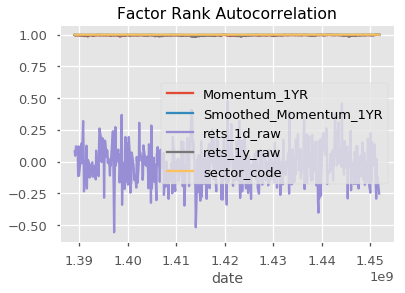

In [24]:
df_ls_fra.plot(title="Factor Rank Autocorrelation");

# Quantile Returns Analysis
Assess whether returns and alpha values distributions match. A balanced Quantiles Returns analysis, means that the alpha factor relies on a high share of portfolio stocks, rather than a small subset of skewed stocks

Alphalens [mean_return_by_quantile documentation.](https://quantopian.github.io/alphalens/alphalens.html#alphalens.performance.mean_return_by_quantile)

```python
def performance.mean_return_by_quantile(factor_data,
                                              ...
                                              demeaned=True,
                                              ...)
```
* factor_data: A MultiIndex DataFrame indexed by date (level 0) and asset (level 1), containing the values for a single alpha factor, forward returns for each period, the factor quantile/bin that factor value belongs to, and (optionally) the group the asset belongs to
* demeaned: this is True by default.  This makes a call to [alphalens.utils.demean_forward_returns](https://quantopian.github.io/alphalens/alphalens.html#alphalens.utils.demean_forward_returns), which takes each factor return and subtracts the mean of all the factor returns in our universe of stocks.
* returns:mean_ret : pd.DataFrame: Mean period wise returns by specified factor quantile.
* Note that it returns a second variable, standard error of the returns.  We will focus on the mean return.

In [25]:
ls_qr = []

for i, factor_name in enumerate(factor_names):
    print("Calculating Quantile returns for: " + factor_name)
    quantile_return, quantile_stderr = al.performance.mean_return_by_quantile(unixt_factor_data[factor_name])
    quantile_return.columns = [factor_name]
    ls_qr.append(quantile_return)
df_ls_qr = pd.concat(ls_qr, axis=1)

Calculating Quantile returns for: Momentum_1YR
Calculating Quantile returns for: Smoothed_Momentum_1YR
Calculating Quantile returns for: rets_1d_raw
Calculating Quantile returns for: rets_1y_raw
Calculating Quantile returns for: sector_code


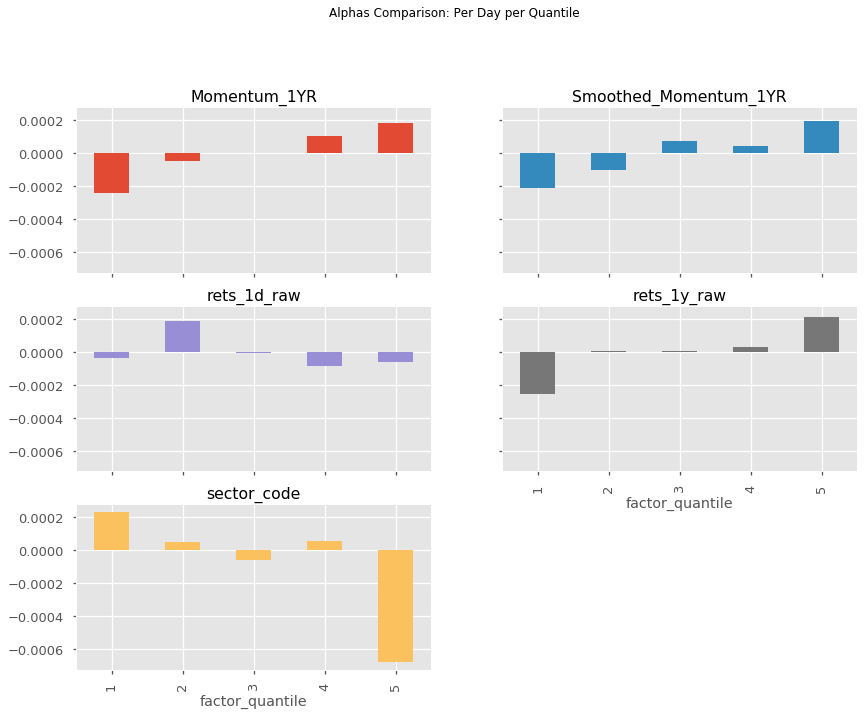

In [26]:
df_ls_qr.plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False,
    title='Alphas Comparison: Per Day per Quantile'
);

# Transfer Coefficient
Running a portfolio optimization exersise yields a set of stocks weights that controls for risk and leverages diversification. If alpha factor and optimization weights are not very different it means:
* The given alpha factor is independent from common risk factors in optimization model

In [27]:
def factor_evaluation(factor_data, factor_names, frequency="daily"):

    ls_sharpe, ls_factor_return, ls_rank_ic, ls_fra, ls_qr = [], [], [], [], []
    unixt_factor_data = {}

    for i, factor_name in enumerate(factor_names):
        
        print("Calculating the factor weighted returns and sharpe-ratio for: " + factor_name)
        factor_return = al.performance.factor_returns(factor_data[factor_name])
        factor_return.columns = [factor_name]
        ls_factor_return.append(factor_return)
        
        sharpe_ratio = compute_sharpe_ratio(ls_factor_return[i], frequency).to_frame('Sharpe ratio')
        ls_sharpe.append(sharpe_ratio)

        print("Calculating the Ranked IC for: " + factor_name)
        rank_ic = al.performance.factor_information_coefficient(factor_data[factor_name])
        rank_ic.columns = [factor_name]
        ls_rank_ic.append(rank_ic)

        unixt_index_data = [(x.timestamp(), y) for x, y in factor_data[factor_name].index.values]
        unixt_factor_data[factor_name] = factor_data[factor_name].set_index(pd.MultiIndex.from_tuples(unixt_index_data, names=['date', 'asset']))

        print("Calculating the FRA for: " + factor_name)
        fra = al.performance.factor_rank_autocorrelation(unixt_factor_data[factor_name]).to_frame()
        fra.columns = [factor_name]
        ls_fra.append(fra)

        print("Calculating Quantile returns for: " + factor_name)
        quantile_return, quantile_stderr = al.performance.mean_return_by_quantile(unixt_factor_data[factor_name])
        quantile_return.columns = [factor_name]
        ls_qr.append(quantile_return)
        
        df_factor_return = pd.concat(ls_factor_return, axis=1)
        df_sharpe = pd.concat(ls_sharpe, axis=0)
        df_rank_ic = pd.concat(ls_rank_ic, axis=1)
        df_fra = pd.concat(ls_fra, axis=1)
        df_qr = pd.concat(ls_qr, axis=1)
        
        df_fra.index = [dt.datetime.fromtimestamp(x) for x in df_fra.index]
    return df_factor_return, df_sharpe, df_rank_ic, df_fra, df_qr

df_factor_return, df_sharpe, df_rank_ic, df_fra, df_qr = factor_evaluation(factor_data, factor_names)

Calculating the factor weighted returns and sharpe-ratio for: Momentum_1YR
Calculating the Ranked IC for: Momentum_1YR
Calculating the FRA for: Momentum_1YR
Calculating Quantile returns for: Momentum_1YR
Calculating the factor weighted returns and sharpe-ratio for: Smoothed_Momentum_1YR
Calculating the Ranked IC for: Smoothed_Momentum_1YR
Calculating the FRA for: Smoothed_Momentum_1YR
Calculating Quantile returns for: Smoothed_Momentum_1YR
Calculating the factor weighted returns and sharpe-ratio for: rets_1d_raw
Calculating the Ranked IC for: rets_1d_raw
Calculating the FRA for: rets_1d_raw
Calculating Quantile returns for: rets_1d_raw
Calculating the factor weighted returns and sharpe-ratio for: rets_1y_raw
Calculating the Ranked IC for: rets_1y_raw
Calculating the FRA for: rets_1y_raw
Calculating Quantile returns for: rets_1y_raw
Calculating the factor weighted returns and sharpe-ratio for: sector_code
Calculating the Ranked IC for: sector_code
Calculating the FRA for: sector_code
Ca

In [28]:
df_factor_return.head()

,Momentum_1YR,Smoothed_Momentum_1YR,rets_1d_raw,rets_1y_raw,sector_code
date,,,,,
2014-01-06 00:00:00+00:00,-0.000161,-0.000054,-0.002961,-0.000842,-0.001748
2014-01-07 00:00:00+00:00,0.003886,0.003893,0.000200,0.006724,-0.002291
2014-01-08 00:00:00+00:00,0.001612,0.001513,-0.000980,0.001189,-0.002361
2014-01-09 00:00:00+00:00,0.000464,0.000418,0.003043,-0.000540,-0.000103
2014-01-10 00:00:00+00:00,-0.002491,-0.002629,-0.000176,-0.003313,-0.003294


In [29]:
df_sharpe

,Sharpe ratio
Momentum_1YR,1.133690
Smoothed_Momentum_1YR,1.101621
rets_1d_raw,0.162868
rets_1y_raw,0.844268
sector_code,-1.646501


In [30]:
df_rank_ic.head()

,Momentum_1YR,Smoothed_Momentum_1YR,rets_1d_raw,rets_1y_raw,sector_code
date,,,,,
2014-01-06 00:00:00+00:00,-0.015975,-0.009565,-0.090375,0.008220,-0.149415
2014-01-07 00:00:00+00:00,0.212508,0.211467,0.042888,0.298971,-0.116103
2014-01-08 00:00:00+00:00,0.089923,0.089733,-0.008119,0.086919,-0.145149
2014-01-09 00:00:00+00:00,0.032607,0.032675,0.002375,-0.133064,0.033885
2014-01-10 00:00:00+00:00,-0.178180,-0.189343,0.028899,-0.299282,-0.215086


In [31]:
df_fra.head()

,Momentum_1YR,Smoothed_Momentum_1YR,rets_1d_raw,rets_1y_raw,sector_code
2014-01-06 01:00:00,NaN,NaN,NaN,NaN,NaN
2014-01-07 01:00:00,0.996552,0.999241,0.080810,0.996486,1.0
2014-01-08 01:00:00,0.993362,0.999198,0.046357,0.994685,1.0
2014-01-09 01:00:00,0.994754,0.999062,0.083818,0.996039,1.0
2014-01-10 01:00:00,0.994261,0.998954,0.120874,0.995899,1.0


In [32]:
df_qr

,Momentum_1YR,Smoothed_Momentum_1YR,rets_1d_raw,rets_1y_raw,sector_code
factor_quantile,,,,,
1,-2.415288e-04,-0.000211,-0.000036,-0.000253,0.000234
2,-4.594508e-05,-0.000103,0.000188,0.000007,0.000049
3,-1.471323e-07,0.000077,-0.000005,0.000004,-0.000058
4,1.051509e-04,0.000042,-0.000088,0.000032,0.000059
5,1.831499e-04,0.000195,-0.000061,0.000213,-0.000678
